# Predicting Diabetic Retinopathy Using a Convolutional Neural Network in Pytorch

Diabetic retinopathy is a condition that affects the retina, the light-sensitive tissue at the back of the eye. It is a complication of diabetes, and is the leading cause of blindness in working-age adults. In the United States (where the data in this project is sourced from), the condition is graded on a scale of 0 to 4, with 0 being no signs of diabetic retinopathy and 4 being severe non-proliferative diabetic retinopathy. The condition is graded by an ophthalmologist, and the grading process is time-consuming and expensive. 

In this project, I will attempt to predict the grade of diabetic retinopathy from a fundus photograph using a convolutional neural network trained using the Pytorch API, in an attempt to prove that computers are going to steal my friends job and render him useless. I will start by treating this as a binary classification task, using this as a means for establishing a baseline level of performance for comparison, before developing a model that treats this as a multi-class classification task.

Two different data sources have been used in this project, both originally from [Kaggle](https://www.kaggle.com). The first dataset is from the [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection) Kaggle competition, containing 3662 fundus photographs, each of which has been graded by an opthamologist. The second dataset comes from the [Diabetic Retinopathy Detection](https://www.kaggle.com/competitions/diabetic-retinopathy-detection) Kaggle competition, containing 2063 fundus photographs, again graded by an opthamologist.

## Setup

In [12]:
# install kaggle and wandb apis
!pip install kaggle wandb -Uq

# import libraries
import cv2
import os
import random
import shutil
import time

import albumentations as A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import wandb

from google.colab import drive
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from tqdm.auto import tqdm

# ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# setup kaggle api
drive.mount('/content/drive/')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/.kaggle/"

# wandb login
wandb.login()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


True

## Data

The data is sourced from the [APTOS 2019 Blindness Detection](https://www.kaggle.com/competitions/aptos2019-blindness-detection) Kaggle competition. This is a multiclass image classification competition that predicts stages of diabetic retinopathy from retinal images. The classes are defined as follows:

0. No diabetic retinopathy
1. Mild
2. Moderate
3. Severe
4. Proliferative diabetic retinopathy

Initially I will flatten the grades 1-4 and turn this into a binary classification task. I am only using the training data because I would need to submit to the Kaggle competition to test performance otherwise. 

I have also supplemented the APTOS 2019 dataset with the training data from the [Diabetic Retinopathy Detection](https://www.kaggle.com/competitions/diabetic-retinopathy-detection) Kaggle competition. This competition was a binary classification task, so this dataset will only be of use for the first stage of this project.

In total, the combination of the two datasets contain 3273 images that show no signs of diabetic retinopathy and 2452 images that show mild, moderate, severe, or proliferative diabetic retinopathy.



### Download Data from Kaggle

In [2]:
# get diabetic retinopathy data
! kaggle competitions download -c aptos2019-blindness-detection

# unzip data files
! unzip -q aptos2019-blindness-detection.zip

# remove surplus files
! rm -r aptos2019-blindness-detection.zip test* sample_submission.csv

# move images to db-ice-cream folder
!mv train_images db-ice-cream

100% 9.51G/9.51G [05:58<00:00, 23.0MB/s]
100% 9.51G/9.51G [05:58<00:00, 28.5MB/s]


In [3]:
# import train labels data
labels = pd.read_csv('train.csv')

# flatten 1, 2, 3, 4 values to 1 to create binary classification task
# where 0 = no disease and 1 = disease
labels.replace([1, 2, 3, 4], 1, inplace=True)

In [4]:
# get image file names to match id_code from the train labels data to the images
img_ids = os.listdir('db-ice-cream/') 

# create subdirectories for each class
!mkdir db-ice-cream/0
!mkdir db-ice-cream/1

# specify path to images
base_dir = 'db-ice-cream'

# for loop to move images to the subdirectory that matches their diagnosis
for img in img_ids:
    try:
        file_name = os.path.splitext(img)[0]
        class_dir = labels.loc[labels.id_code==file_name, 'diagnosis'].values[0]  
        os.rename(f'{base_dir}/{img}', f'{base_dir}/{class_dir}/{img}')
    except:
        print('error')
        pass

In [5]:
# check total images in each class
!ls db-ice-cream/0 | wc -l
!ls db-ice-cream/1 | wc -l

1805
1857


### Download Extra Data from Github

In [ ]:
# get extra data
!git clone 'https://github.com/javathunderman/retinopathy-dataset.git'

# move files
!mv retinopathy-dataset/nosymptoms/* db-ice-cream/0/
!mv retinopathy-dataset/symptoms/* db-ice-cream/1/

# remove original subdirectroy
! rm -r retinopathy-dataset

Cloning into 'retinopathy-dataset'...
remote: Enumerating objects: 2072, done.
remote: Total 2072 (delta 0), reused 0 (delta 0), pack-reused 2072
Receiving objects: 100% (2072/2072), 1.84 GiB | 25.26 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (2064/2064), done.


In [ ]:
# check total images in each class
!ls db-ice-cream/0 | wc -l
!ls db-ice-cream/1 | wc -l

3273
2452


## Data Preparation

There are two important steps in the process of preparing image data for deep learning projects: preprocessing and augmentation.

The purpose of image preprocessing for deep learning models is to prepare the images in the training dataset for modeling. This is done by resizing the images to a standard size, converting the images to grayscale, and converting the images to arrays.

The purpose of image augmentation for deep learning models is to increase the size of the training dataset by creating modified versions of the images in the training dataset. This is done by applying random transformations to the images such as horizontal flips, vertical flips, random zooms, random rotations, and random shifts. The goal of image augmentation is to expand the training dataset in order to improve the performance and ability of the model to generalize. Image augmentation is only used with the training dataset, and not the test dataset. This is because the test dataset should be used to provide an unbiased evaluation of a final model fit on the training dataset.

### Image Preprocessing

Lets start by randomly sampling from the two target classes (0 = no retinopathy, 1 = retinopathy) and visualising the images to get a bit of an idea of what we are working with.


In [6]:
# create empty dataframe
img_sample = pd.DataFrame()

# specify number of samples to take from each class
num_samples = 5

# loop through subfolders
for folder in os.listdir(base_dir):
    # create empty list to store image paths
    imgs = []
    # loop through images in subfolder
    for img in os.listdir(os.path.join(base_dir, folder)):
        # append image path to list
        imgs.append(os.path.join(base_dir, folder, img))
    # sample 10 images from list
    sample = random.sample(imgs, num_samples)
    # create dataframe of sampled images
    df_temp = pd.DataFrame(sample, columns=['img_path'])
    # add class label
    df_temp['target'] = int(folder)
    # append to main dataframe
    img_sample = img_sample.append(df_temp, ignore_index=True)

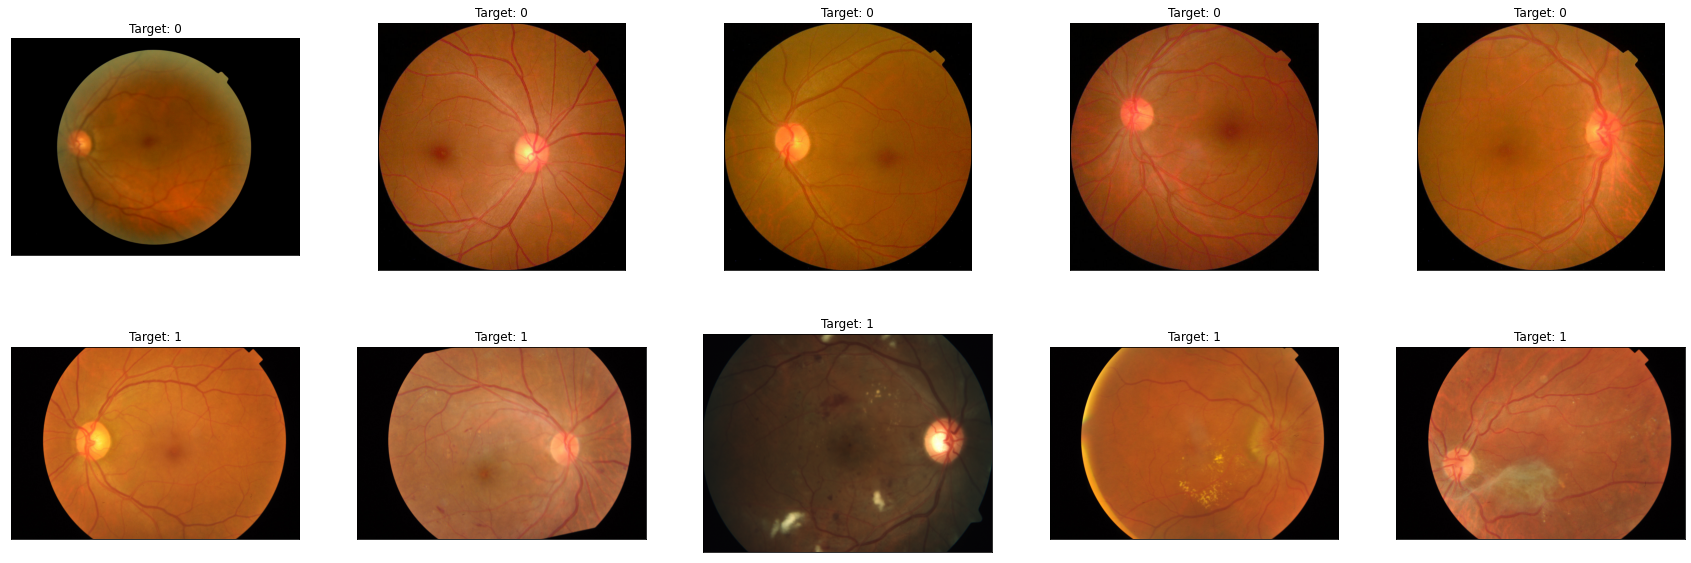

In [7]:
# specify plot figure size
fig = plt.figure(figsize=(30, 10))

# loop through each class
for label in sorted(img_sample.target.unique()):
    # get image paths
    paths = img_sample[img_sample['target'] == label]['img_path'].values
    # loop through image paths
    for i, path in enumerate(paths):
        # create subplot
        ax = fig.add_subplot(2, num_samples, label * num_samples + i + 1, xticks=[], yticks=[])
        # read image from path
        img = cv2.imread(path)
        # convert img to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # plot image
        plt.imshow(img)
        # set label as subplot title
        ax.set_title(f'Target: {label}')

There's a few things that are immediately obvious about these images, that will have to be addressed in the process of preprocessing them for the model:

- The images come in a few different shapes and sizes
- Some images are more 'zoomed in' than others
- Some images are much darker than others
- There appears to be a certain amount of blurring in some images that suggests we need to account for image quality as a factor

As stated above, we need to preprocess and augment the images. Preprocessing is intended to maximize the 'signal' and minimize the 'noise'. We want to process the images in a way that gives the model the best possible chance at identifying the presence of diabetic retinopathy in any image. This also means that we want to identify and address the ways the images differ that is not relevant to the classification task itself (such as the issues identified above). 

If we convert the imagest to greyscale, resize them so that all images are 512x512, and carry out a process called 'linear blending' (adding two images, in this case the original image and the transformed version of the same image, by calculating the weighted sum of their arrays) to improve the quality of the images by reducing the weight of the black background on each image, we will start to see how we can significantly improve the model's chances of correctly classifying each image.

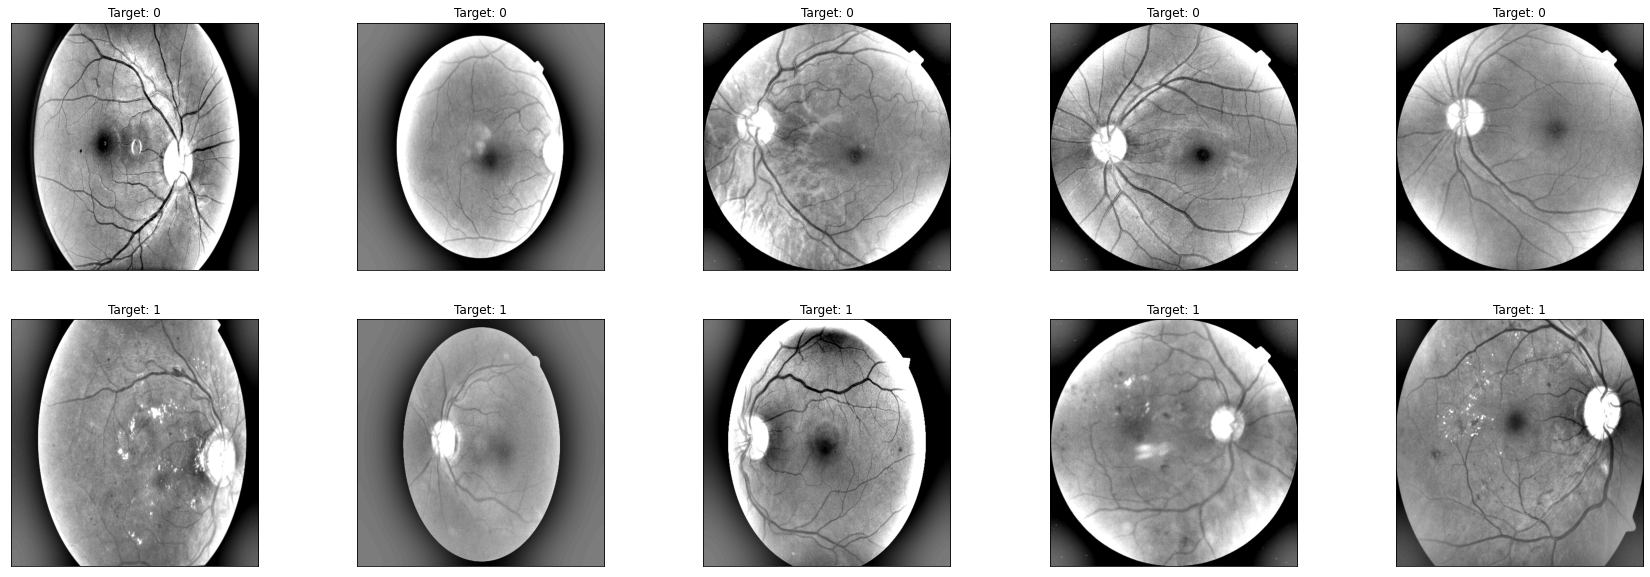

In [ ]:
# specify plot figure size
fig = plt.figure(figsize=(30, 10))

# loop through each class
for label in sorted(img_sample.target.unique()):
    # get image paths
    paths = img_sample[img_sample['target'] == label]['img_path'].values
    # loop through image paths
    for i, path in enumerate(paths):
        # create subplot
        ax = fig.add_subplot(2, num_samples, label * num_samples + i + 1, xticks=[], yticks=[])
        # read image from path
        img = cv2.imread(path)
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize image
        img = cv2.resize(img, (512, 512))
        # apply linear blend
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 512/10),-4 ,128)

        # plot image
        plt.imshow(img, cmap='gray')
        # set label as subplot title
        ax.set_title(f'Target: {label}')

The steps taken above help inform the final preprocessing steps we will take. We can create a function to crop out any black border such that the image of the retina is at each edge of the square, maximising the total pixels that contain useful information.

Following this, we can also create a function that combines all of the preprocessing steps, to reduce the amount of code we have to write.

In [8]:
# function to crop out black borders
def crop_from_gray(img,tol=7):
    # for gray scale images
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # for color images
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        # return original if image is too dark
        if (check_shape == 0):
            return img
        else:
            # crop the image
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            # stack as a single image
            img = np.stack([img1,img2,img3],axis=-1)

        return img

In [9]:
# function for preprocessing images
def preprocess(img_path, sigmaX=10):
    # read image
    img = cv2.imread(img_path)
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # get image dimensions
    height, width, depth = img.shape
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    # create circular crop around image center
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)

    # crop image to remove black borders
    img = crop_from_gray(img)
    # resize image
    img = cv2.resize(img, (512, 512))
    # apply linear blend
    img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)

    return img

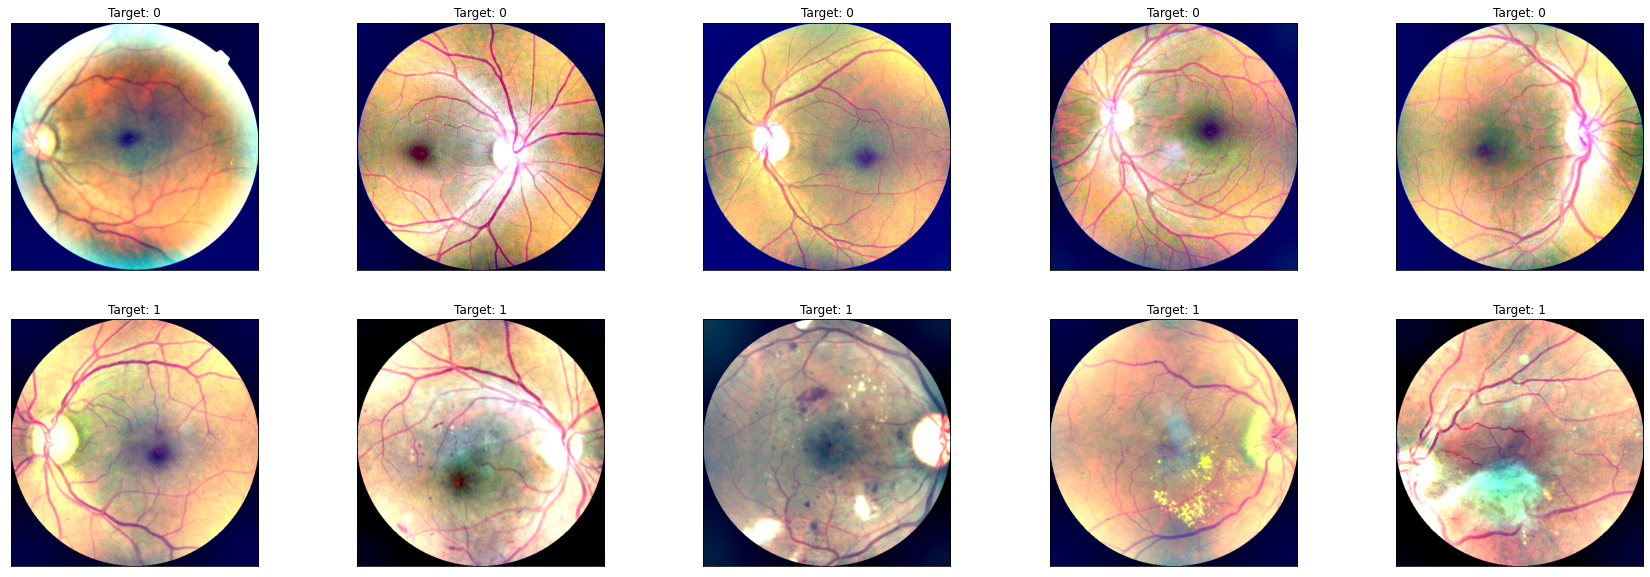

In [10]:
# specify plot figure size
fig = plt.figure(figsize=(30, 10))

# loop through each class
for label in sorted(img_sample.target.unique()):
    # get image paths
    paths = img_sample[img_sample['target'] == label]['img_path'].values
    # loop through image paths
    for i, path in enumerate(paths):
        # create subplot
        ax = fig.add_subplot(2, num_samples, label * num_samples + i + 1, xticks=[], yticks=[])
        # apply preprocessing function
        img = preprocess(path, sigmaX=100)

        # plot image
        plt.imshow(img)
        # set label as subplot title
        ax.set_title(f'Target: {label}')

#### Custom Pytorch Class

In [13]:
class preprocess_images(datasets.ImageFolder):
  def __init__(self, root, loader=default_loader, is_valid_file=None):
    super(preprocess_images, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
    
  def __getitem__(self, index):
    image_path, target = self.samples[index]
    
    # preprocessing function
    img = preprocess(image_path, sigmaX=80)
    
    # convert img from np.array to torch.tensor
    sample = transforms.ToTensor()(img)
    
    return sample, target

## Image Augmentation

#### Custom Albumentations Class

In [ ]:
class AlbumentationsDataset(Dataset):
    """ Preprocessing & Augmenting Images """
    def __init__(self, path, labels, transform=None):
        self.path = path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        label = self.labels[idx]
        path = self.path[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']
            total_time = (time.time() - start_t)
            
        return image, label, total_time

In [ ]:
# Same transform with torchvision_transform
albumentations_transform = A.Compose([
    A.Resize(300, 300), 
    A.RandomCrop(224, 224),
    A.ColorJitter(p=1), 
    A.HorizontalFlip(p=1), 
    A.RandomBrightnessContrast(p=0.2),
    transforms.ToTensor()
])

In [ ]:
# After applying transforms
albumentation_dataset = AlbumentationsDataset(
    path = (f'{base_dir}/'),
    labels=
    transform = albumentations_transform
)

img, annot = albumentation_dataset[0]

ValueError: ignored

## Load, Preprocess, & Augment Data

In [ ]:
# specify path location for dataset
dataset = preprocess_images(f'{base_dir}/')

# specify images as dataset
# dataset = datasets.ImageFolder(data_dir, transform=preprocess_images)

# load data
# dataloader = DataLoader(data, batch_size=32, shuffle=True)

## Train/Test Split

In [ ]:
# specify train, validation, and test sets
train, test = random_split(dataset, [0.8, 0.2])



# load data
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=2)
# val_loader = DataLoader(val, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test, batch_size=32, shuffle=True, num_workers=2)

4580
1145


### Check Data

It's worth checking the data to make sure the process of loading and transforming the data has worked as expected, because there are several steps that could potentially produce errors.

First, lets check that the size of the train/test splits looks about right.

In [ ]:
print(len(train))
# print(len(val))
print(len(test))

We can also plot a chunk of the first batch of images just to make sure the preprocessing and augmenting steps look like they've worked as expected. They should look like the final set of processed images above.

In [ ]:
# helper function to visualize images

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

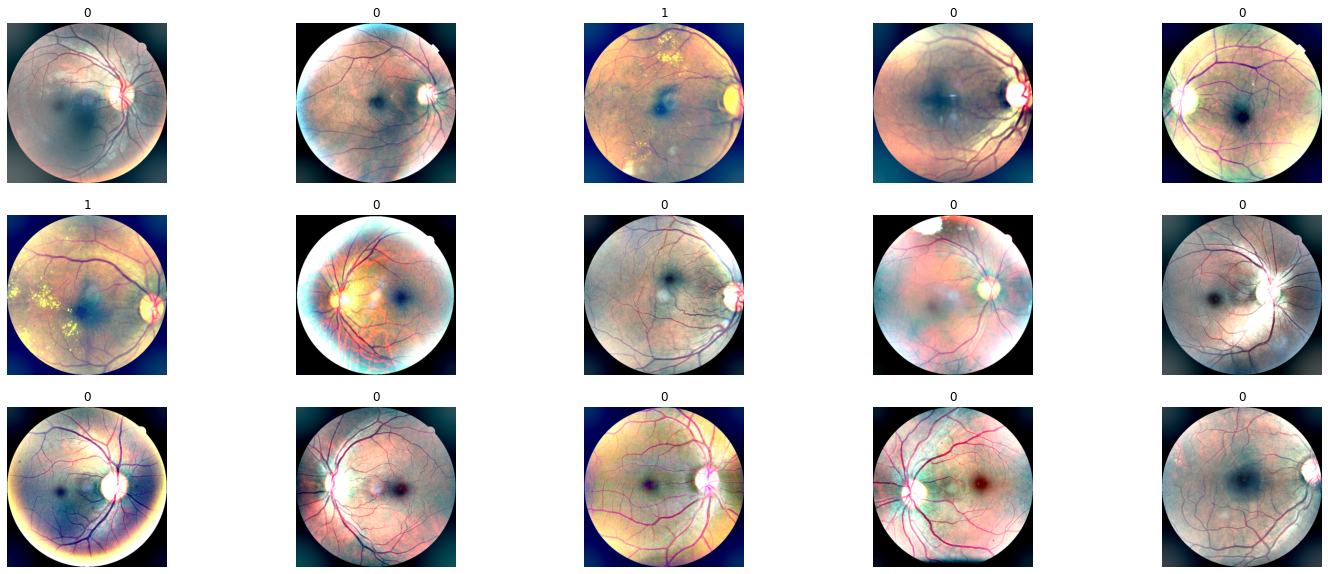

In [ ]:
# obtain one batch of training images
images, labels = next(iter(train_loader))

# plot 20 images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(15):
    ax = fig.add_subplot(3, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx], normalize=False, ax=ax)
    ax.set_title(labels[idx].item())

Finally, we can check the shape and size of the images, and calculate the total number of pixels. This is useful for a) sense-checking the transformation process and identifying any issues, and b) getting an idea of what we're working with, to inform decisions around the network architecture.

In [ ]:
# check the shape of the images
images[0].shape

torch.Size([3, 512, 512])

In [ ]:
# check how many pixels are in each image
images[0].shape[1] * images[0].shape[2]

262144

# Convolutional Neural Network (CNN)

## Specify W&B Config

In [ ]:
config = dict(
    epochs=10,
    classes=2,
    kernels=[16, 32],
    batch_size=32,
    learning_rate=0.001,
    # weight_decay=1e-4,
    momentum=0.9,
    dataset='diabetic-ice-cream',
    architecture='CNN')

## Helper Functions

### Model Pipeline

In [ ]:
def model_pipeline(hyperparameters):

    # initiate wandb
    with wandb.init(project='diabetic-ice-cream', config=hyperparameters):
      # access hyperparameters from config
      config = wandb.config

      # make model, data, and optimization
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # train
      train(model, train_loader, criterion, optimizer, config)

      # test
      test(model, test_loader)

    return model

In [ ]:
def make(config):
    # make train and test data
    train, test = get_data(train=True), get_data(train=False)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # define model
    model = CNN(config.kernels, config.classes).to(device)

    # specify loss and optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), 
        lr=config.learning_rate, 
        # weight_decay=config.weight_decay, 
        momentum=config.momentum)
    
    return model, train_loader, test_loader, criterion, optimizer

In [ ]:
def get_data(slice=5, train=True):

    sub_dataset = torch.utils.data.Subset(
      dataset, indices=range(0, len(dataset), slice))
    
    return sub_dataset

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
    return loader

### CNN Architecture

In [ ]:
# specify convolutional neural network

class CNN(nn.Module):
    def __init__(self, kernels, classes=2):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(524288, classes)
        
        # self.fc2 = nn.Linear(512, classes)
        # self.dropout = nn.Dropout(p=0.2)
        # self.fc3 = nn.Linear(120, 84)
        # self.fc4 = nn.Linear(84, 10)
        # self.fc5 = nn.Linear(10, classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        # out = self.dropout(out)
        # out = F.relu(self.fc2(out))
        # out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.fc4(out)
        # out = self.fc5(out)
        
        return out

### Model Training

In [ ]:
def train(model, loader, criterion, optimizer, config):
    # establish wandb tracking
    wandb.watch(model, criterion, log="all", log_freq=10)

    # train model
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # report metrics after 25 batches
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # optimizer
    optimizer.step()

    return loss

### Training Logs

In [ ]:
def train_log(loss, example_ct, epoch):
    # metrics to track in wandb
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

### Model Testing

In [ ]:
def test(model, test_loader):
    model.eval()

    # evaluate performance on test data
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")
        
        wandb.log({"test_accuracy": correct / total})

    # save model
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

## Run CNN Pipeline

In [ ]:
# run model pipeline
model = model_pipeline(config)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=524288, out_features=2, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 00768 examples: 0.672
Loss after 01561 examples: 0.667
Loss after 02354 examples: 0.611
Loss after 03154 examples: 0.660
Loss after 03947 examples: 0.577
Loss after 04740 examples: 0.313
Loss after 05540 examples: 0.467
Loss after 06333 examples: 0.294
Loss after 07126 examples: 0.379
Loss after 07926 examples: 0.445
Loss after 08719 examples: 0.513
Loss after 09512 examples: 0.236
Loss after 10305 examples: 0.326
Loss after 11105 examples: 0.472
Accuracy of the model on the 1145 test images: 88.296943%
